In [1]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (Matplotlib에서 한글 깨짐 방지)
import matplotlib.pyplot as plt

plt.rc("font", family="NanumGothic")  # Windows 사용자의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 기본 라이브러리
import polars as pl
import pandas as pd
import seaborn as sns

# 시각화용 색상 팔레트
color_palette = sns.color_palette("Set2", as_cmap=False)

In [2]:
상품집계_고객집계_클러스터링전 = pl.read_csv('./dataset/상품집계_고객집계_클러스터링전.csv')

In [3]:
상품집계_고객집계_클러스터링전.head()

고객ID,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_총점수,거래기간(개월),연령대,최대_보유상품종류,평균_보유상품종류,최대_고객등급
i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,str
7449820487,0.0,0.0,0.0,0.0,0.0,70.282527,36,50,0,0,"""일반등급"""
6406534297,5.4733e6,3.15e7,0.0,61000.0,0.0,1602.815556,36,50,3,2,"""일반등급"""
6298470811,1.0613e6,2.6419e6,0.0,322.580645,1.2226e6,882.57164,36,30,3,2,"""일반등급"""
5619863903,545161.290323,9.4323e6,0.0,0.0,0.0,381.741935,36,50,3,1,"""일반등급"""
7674680602,6.5839e6,0.0,0.0,0.0,0.0,517.462366,36,60,1,1,"""일반등급"""


In [5]:
clustering_origin = 상품집계_고객집계_클러스터링전[['고객ID', '연령대', '평균_입출금예금', '평균_기타예금', '평균_비이자상품', '평균_카드', '평균_대출', '평균_보유상품종류']].clone()

# 비지도학습 기반 분류 (평균_입출금예금, 평균_기타예금,	평균_비이자상품, 평균_카드,	평균_대출,	평균_보유상품종류, best k 찾기)

In [15]:
# 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
import pandas as pd

In [16]:
# 데이터 준비
df = clustering_origin.clone()
# Polars에서 수치형 컬럼만 추출
numeric_columns = [col for col, dtype in df.schema.items() if dtype in pl.NUMERIC_DTYPES]
exclude_cols = ["고객ID", "연령대"]  # 분석에서 제외할 컬럼
use_columns = [col for col in numeric_columns if col not in exclude_cols]

X = df.select(use_columns)
X_scaled = StandardScaler().fit_transform(X.to_numpy())

In [17]:
X

평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출금액,평균_보유상품종류
f64,f64,f64,f64,f64,i64
0.0,0.0,0.0,0.0,1.85e6,1
722580.645161,1.3355e6,0.0,1.0152e6,0.0,2
190322.580645,6451.612903,0.0,0.0,0.0,1
7.8290e6,0.0,0.0,6129.032258,0.0,1
200000.0,0.0,0.0,10000.0,5.65e6,2
…,…,…,…,…,…
122580.645161,0.0,0.0,510322.580645,0.0,2
54838.709677,0.0,0.0,0.0,0.0,0
1.8e6,0.0,0.0,0.0,0.0,1


In [18]:
X_scaled

array([[-3.19969067e-01, -2.49223737e-01, -5.39406903e-02,
        -3.85451307e-01, -3.12338131e-02, -1.98341978e-01],
       [-1.53097826e-01, -5.76187613e-04, -5.39406903e-02,
         2.91513735e+00, -2.60702280e-01,  8.74002251e-01],
       [-2.76016374e-01, -2.48022541e-01, -5.39406903e-02,
        -3.85451307e-01, -2.60702280e-01, -1.98341978e-01],
       ...,
       [ 9.57191128e-02, -2.49223737e-01, -5.39406903e-02,
        -3.85451307e-01, -2.60702280e-01, -1.98341978e-01],
       [-2.70801648e-01, -2.49223737e-01, -5.39406903e-02,
        -1.18006087e-01, -2.60702280e-01, -1.27068621e+00],
       [ 2.94175931e-02, -2.49223737e-01, -5.39406903e-02,
         1.71530468e+00, -2.60702280e-01, -1.98341978e-01]])

## k means

In [19]:
results = []

# k값을 2부터 9까지 반복하며 클러스터 평가
for k in range(2, 10):
    # KMeans 클러스터링 모델 학습
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # silhouette score 계산 시 너무 느려지는 걸 방지하기 위해 1만 개만 샘플링
    X_sampled, labels_sampled = resample(
        X_scaled, labels,
        n_samples=min(10000, len(X_scaled)),
        random_state=42
    )

    # 세 가지 평가 지표 계산
    results.append({
        "k": k,
        "silhouette": silhouette_score(X_sampled, labels_sampled),          # 군집 간 분리 + 내부 응집
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),     # 분산 기반 평가
        "davies_bouldin": davies_bouldin_score(X_scaled, labels)            # 군집 간 거리 / 내부 거리 (낮을수록 좋음)
    })

# 리스트 → DataFrame 변환
result_kmeans = pd.DataFrame(results)

# 각 지표에 대해 순위 계산
# silhouette / ch는 클수록 좋으므로 내림차순(ascending=False)
# db는 작을수록 좋으므로 오름차순(ascending=True)
result_kmeans["rank_silhouette"] = result_kmeans["silhouette"].rank(ascending=False)
result_kmeans["rank_ch"] = result_kmeans["calinski_harabasz"].rank(ascending=False)
result_kmeans["rank_db"] = result_kmeans["davies_bouldin"].rank(ascending=True)

# 평균 순위 계산 → 종합 평가 지표로 활용
result_kmeans["rank_avg"] = result_kmeans[["rank_silhouette", "rank_ch", "rank_db"]].mean(axis=1)

# 평균 순위가 가장 낮은(즉, 전체적으로 가장 높은 평가를 받은) k를 Best k로 선정
best_k_rank = result_kmeans.loc[result_kmeans["rank_avg"].idxmin(), "k"]

## gmm

In [23]:
results = []

# k값을 2부터 9까지 반복하며 GMM 클러스터 평가
for k in range(2, 10):
    # GMM 클러스터링 모델 학습
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_scaled)

    # silhouette score 계산 시 너무 느려지는 걸 방지하기 위해 1만 개만 샘플링
    X_sampled, labels_sampled = resample(
        X_scaled, labels,
        n_samples=min(10000, len(X_scaled)),
        random_state=42
    )

    # 세 가지 평가 지표 계산
    results.append({
        "k": k,
        "silhouette": silhouette_score(X_sampled, labels_sampled),          # 군집 간 분리 + 내부 응집
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),     # 분산 기반 평가
        "davies_bouldin": davies_bouldin_score(X_scaled, labels)            # 군집 간 거리 / 내부 거리 (낮을수록 좋음)
    })

# 리스트 → DataFrame 변환
result_gmm = pd.DataFrame(results)

# 각 지표에 대해 순위 계산
# silhouette / ch는 클수록 좋으므로 내림차순(ascending=False)
# db는 작을수록 좋으므로 오름차순(ascending=True)
result_gmm["rank_silhouette"] = result_gmm["silhouette"].rank(ascending=False)
result_gmm["rank_ch"] = result_gmm["calinski_harabasz"].rank(ascending=False)
result_gmm["rank_db"] = result_gmm["davies_bouldin"].rank(ascending=True)

# 평균 순위 계산 → 종합 평가 지표로 활용
result_gmm["rank_avg"] = result_gmm[["rank_silhouette", "rank_ch", "rank_db"]].mean(axis=1)

# 평균 순위가 가장 낮은(즉, 전체적으로 가장 높은 평가를 받은) k를 Best k로 선정
best_k_rank_gmm = result_gmm.loc[result_gmm["rank_avg"].idxmin(), "k"]

## k means vs gmm
- 999_003_분석_1_clustering_총점수_전체_0314.ipynb 참고

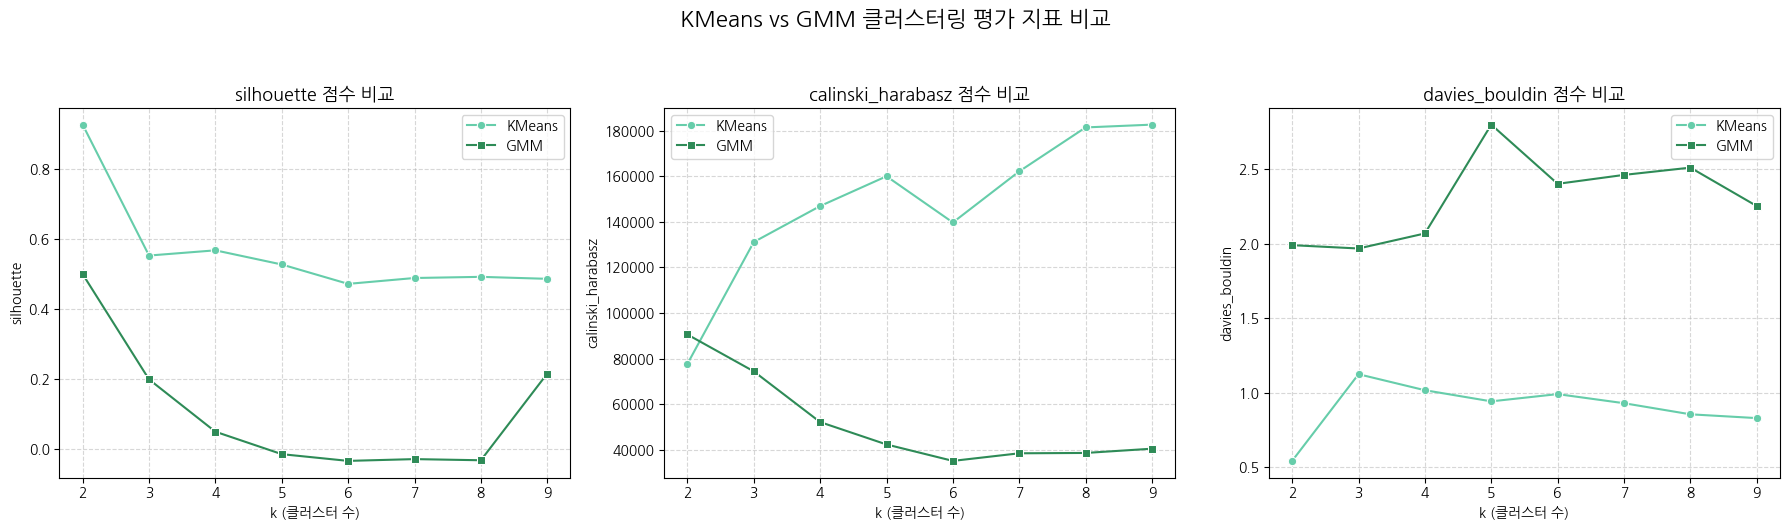

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 비교할 지표 리스트
metrics = ["silhouette", "calinski_harabasz", "davies_bouldin"]

# 서브플롯 준비 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# 지표별로 subplot에 추가
for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # KMeans 점수 라인
    sns.lineplot(data=result_kmeans, x="k", y=metric, marker="o", label="KMeans", ax=ax, color="mediumaquamarine")
    
    # GMM 점수 라인
    sns.lineplot(data=result_gmm, x="k", y=metric, marker="s", label="GMM", ax=ax, color="seagreen")
    
    # 그래프 꾸미기
    ax.set_title(f"{metric} 점수 비교", fontsize=13)
    ax.set_xlabel("k (클러스터 수)")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

plt.suptitle("KMeans vs GMM 클러스터링 평가 지표 비교", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


## 최적 K 정하기

In [25]:
# elbow point 자동 탐지 코드로 최적 k 찾아보기

In [26]:
!pip install kneed

### k means

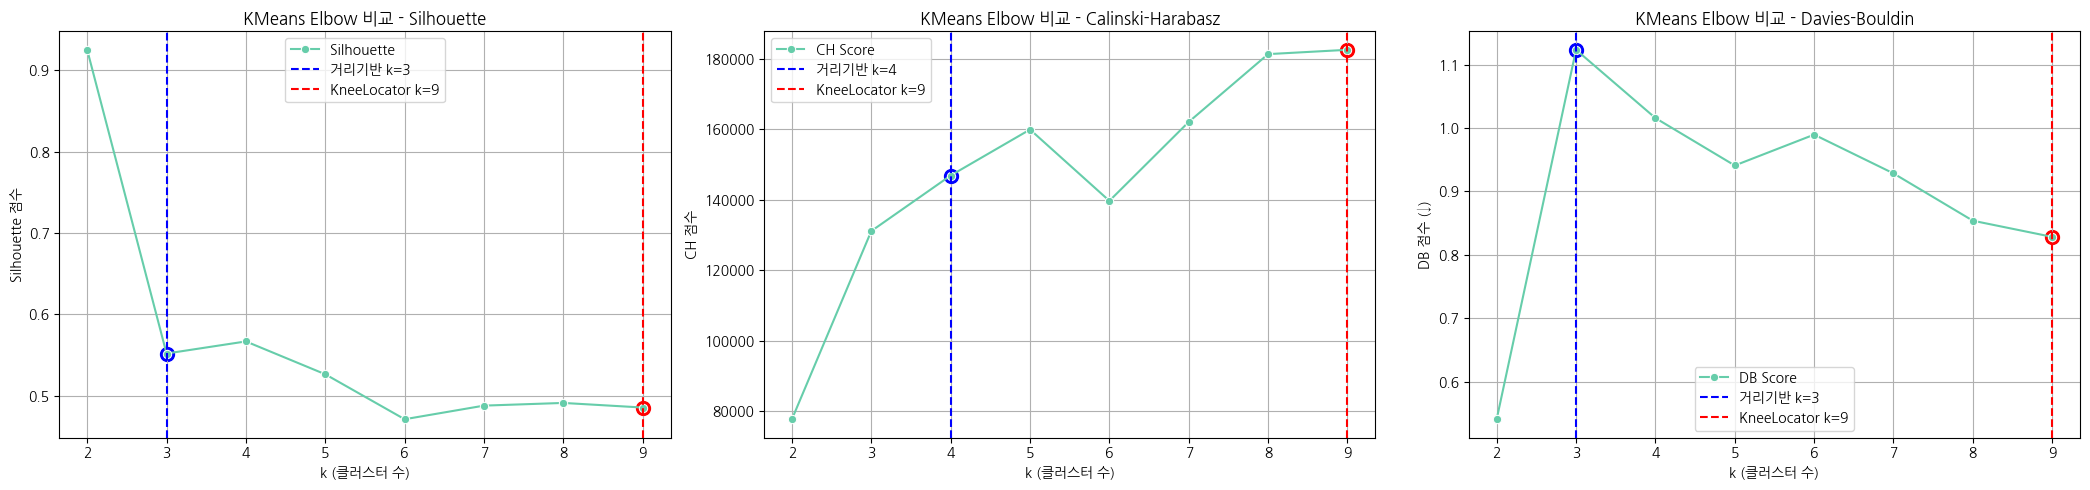

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kneed import KneeLocator

# ✅ 거리기반 elbow 계산 함수
def find_elbow_point(df, score_col):
    x = df["k"].to_numpy()
    y = df[score_col].to_numpy()
    start = np.array([x[0], y[0]])
    end = np.array([x[-1], y[-1]])
    distances = []
    for i in range(len(x)):
        point = np.array([x[i], y[i]])
        vec_line = end - start
        vec_point = point - start
        proj_len = np.dot(vec_line, vec_point) / np.linalg.norm(vec_line)
        proj_point = start + proj_len * vec_line / np.linalg.norm(vec_line)
        dist = np.linalg.norm(point - proj_point)
        distances.append(dist)
    best_idx = int(np.argmax(distances))
    return int(x[best_idx])

# ✅ KneeLocator 방식
def find_elbow_kneedf(df, metric, direction="increasing"):
    x = df["k"].to_list()
    y = df[metric].to_list()
    curve_type = "convex" if direction == "increasing" else "concave"
    kneedle = KneeLocator(x, y, curve=curve_type, direction=direction)
    return kneedle.knee

# ✅ 개별 지표 처리 ------------------------------

# Silhouette
df_sil = result_kmeans[["k", "silhouette"]].copy()
elbow_kmeans_dist_sil = find_elbow_point(df_sil, "silhouette")
elbow_kmeans_knee_sil = find_elbow_kneedf(df_sil, "silhouette", direction="increasing")
score_dist_sil = df_sil[df_sil["k"] == elbow_kmeans_dist_sil]["silhouette"].values[0]
score_knee_sil = df_sil[df_sil["k"] == elbow_kmeans_knee_sil]["silhouette"].values[0]

# CH
df_ch = result_kmeans[["k", "calinski_harabasz"]].copy()
elbow_kmeans_distance_ch = find_elbow_point(df_ch, "calinski_harabasz")
elbow_kmeans_knee_ch = find_elbow_kneedf(df_ch, "calinski_harabasz", direction="increasing")
score_dist_ch = df_ch[df_ch["k"] == elbow_kmeans_distance_ch]["calinski_harabasz"].values[0]
score_knee_ch = df_ch[df_ch["k"] == elbow_kmeans_knee_ch]["calinski_harabasz"].values[0]

# DB
df_db = result_kmeans[["k", "davies_bouldin"]].copy()
elbow_kmeans_distance_db = find_elbow_point(df_db, "davies_bouldin")
elbow_kmeans_knee_db = find_elbow_kneedf(df_db, "davies_bouldin", direction="decreasing")
score_dist_db = df_db[df_db["k"] == elbow_kmeans_distance_db]["davies_bouldin"].values[0]
score_knee_db = df_db[df_db["k"] == elbow_kmeans_knee_db]["davies_bouldin"].values[0]

# ✅ 시각화 ------------------------------

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# --- Silhouette
sns.lineplot(data=df_sil, x="k", y="silhouette", ax=axes[0], color="mediumaquamarine", marker="o", label="Silhouette")
axes[0].axvline(x=elbow_kmeans_dist_sil, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_dist_sil}")
axes[0].scatter(elbow_kmeans_dist_sil, score_dist_sil, color="blue", s=100)
axes[0].axvline(x=elbow_kmeans_knee_sil, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_sil}")
axes[0].scatter(elbow_kmeans_knee_sil, score_knee_sil, color="red", s=100)
axes[0].set_title("KMeans Elbow 비교 - Silhouette")
axes[0].set_xlabel("k (클러스터 수)")
axes[0].set_ylabel("Silhouette 점수")
axes[0].legend()
axes[0].grid(True)

# --- CH
sns.lineplot(data=df_ch, x="k", y="calinski_harabasz", ax=axes[1], color="mediumaquamarine", marker="o", label="CH Score")
axes[1].axvline(x=elbow_kmeans_distance_ch, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_distance_ch}")
axes[1].scatter(elbow_kmeans_distance_ch, score_dist_ch, color="blue", s=100)
axes[1].axvline(x=elbow_kmeans_knee_ch, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_ch}")
axes[1].scatter(elbow_kmeans_knee_ch, score_knee_ch, color="red", s=100)
axes[1].set_title("KMeans Elbow 비교 - Calinski-Harabasz")
axes[1].set_xlabel("k (클러스터 수)")
axes[1].set_ylabel("CH 점수")
axes[1].legend()
axes[1].grid(True)

# --- DB
sns.lineplot(data=df_db, x="k", y="davies_bouldin", ax=axes[2], color="mediumaquamarine", marker="o", label="DB Score")
axes[2].axvline(x=elbow_kmeans_distance_db, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_distance_db}")
axes[2].scatter(elbow_kmeans_distance_db, score_dist_db, color="blue", s=100)
axes[2].axvline(x=elbow_kmeans_knee_db, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_db}")
axes[2].scatter(elbow_kmeans_knee_db, score_knee_db, color="red", s=100)
axes[2].set_title("KMeans Elbow 비교 - Davies-Bouldin")
axes[2].set_xlabel("k (클러스터 수)")
axes[2].set_ylabel("DB 점수 (↓)")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


# 라벨링 후 내보내기